# View Extracted Pixel Exposure Sky background and noise  from Calexp and CalexpBackground and CCD Visits for LSSTComCamSim

- Just read pandas dataframe and show plots

- author Sylvie Dagoret-Campagne
- creation date 2024-05-11
- last update 2024-05-29 : Fit a straight line
- affiliation : IJCLab
- kernel : **w_2024_16**

 
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

https://tigress-web.princeton.edu/~lkelvin/pipelines/current/drp_pipe/LSSTComCamSim/nightly-validation-ops-rehearsal-3/

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time
from astropy.modeling import models, fitting

In [3]:
import matplotlib.dates as mdates
#month_locator = mdates.MonthLocator(interval=1)
#day_locator = mdates.DayLocator(interval=1)
#year_month_formatter = mdates.DateFormatter("%Y-%m") 

from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")

In [4]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Set environment for USDF Rubin Science Platform


In [5]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir

In [6]:
fdir = get_data_dir()
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'baseline')

In [7]:
import sys
sys.path.append('../lib')
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections import *

LSST site name validated as LSST observatory


In [8]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/home/d/dagoret/repos/repos_w_2024_17/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


In [9]:
all_Sigb = {}
all_SigbInv = {}
for index,f in enumerate(filter_tagnames): 
    wl = pc.bandpass_inst[f].wavelen
    tr = pc.bandpass_inst[f].sb
    Sigb = np.trapz(tr/wl,wl)
    all_Sigb[f] = Sigb 
    all_SigbInv[f] = 1/Sigb 

In [10]:
pd.DataFrame(all_Sigb, index=['Sigmab']).round(4)

,u,g,r,i,z,y
Sigmab,0.058,0.1544,0.1157,0.0855,0.0579,0.0309


In [11]:
pd.DataFrame(all_SigbInv, index=['SigmabInv']).round(4)

,u,g,r,i,z,y
SigmabInv,17.2412,6.4783,8.6437,11.6967,17.2794,32.3165


### For fitting

In [12]:
model = models.Linear1D()
fitter = fitting.LinearLSQFitter() 

In [13]:
from lsst.daf.butler import Butler
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"
collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collections = [collection2]
collectionn = collection2
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_photocalib = f"ccdVisittractpatch_{collectionStr}_calexpinfo.csv"
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LSSTComCamSim'
skymapName = "ops_rehersal_prep_2k_v1"
where_clause = "instrument = \'" + instrument+ "\'"
NDET = 9
suptitle=  collectionStr

suptitle = collectionStr + f" inst = {instrument} "

In [14]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4


## Read inputs

### Access CCD visit table

In [15]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LSSTComCamSim
collections = ['LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612']


In [16]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': instrument}, collections = collections )    

In [17]:
ccd_visit_table["ccdVid"] = ccd_visit_table.index -  ccd_visit_table.index[0]
ccd_visit_table["Vid"] = ccd_visit_table["visitId"]  -   ccd_visit_table["visitId"].iloc[0]

In [18]:
#subtract the a bug number to have normal dates
ccd_visit_table["nightObs"] = ccd_visit_table.apply(lambda x: x['visitId']//100_000, axis=1)
ccd_visit_table["nightObs"]

ccdVisitId
730865860864    70240403
730865860865    70240403
730865860866    70240403
730865860867    70240403
730865860868    70240403
                  ...   
730866060292    70240403
730866060293    70240403
730866060294    70240403
730866060295    70240403
730866060296    70240403
Name: nightObs, Length: 6301, dtype: int64

In [19]:
# get time
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

In [20]:
# get airmass
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

In [21]:
# select the missing quantities (the time)
ccd_visit_table_subset = ccd_visit_table[["Time","obsStart"]]

### Read pandas dataframe containing the tract-patch decomposition of visits

In [22]:

# need the visit file because observation date is missing
file_selected_visits = os.path.join("../Visits",fn_ccdVisit_tracts_patches)
df1 = pd.read_csv(file_selected_visits,index_col=0)

### Read the dataframe with the extracted parameters from calexp,calexpBackground

In [23]:
df = pd.read_csv(fn_ccdVisit_photocalib,index_col=0)

In [24]:
df

,idx,visitId,ccdVisitId,band,detector,zeroPoint,airmass,skyBg,skyNoise,expTime,...,std_bkg_m,sigMad_bkg_m,mu_pisr,med_pisr,std_pisr,sigMad_pisr,mu_pisr_m,med_pisr_m,std_pisr_m,sigMad_pisr_m
0,0,7024040300001,730865860864,r,0,31.258871,1.050426,1703.7678,34.471790,30.0,...,0.864976,1.015668,1721.3032,1705.3062,560.02400,35.219713,1704.305279,1704.212891,34.530724,34.511895
1,1,7024040300001,730865860865,r,1,31.238535,1.051820,1674.7633,32.659890,30.0,...,0.564138,0.635969,1690.4606,1676.0632,545.50934,33.355604,1675.247579,1675.147705,32.774709,32.766781
2,2,7024040300001,730865860866,r,2,31.259706,1.053236,1709.5557,33.396534,30.0,...,0.370159,0.348751,1724.1127,1710.7158,503.87857,34.082245,1709.959175,1709.869019,33.555741,33.537672
3,3,7024040300001,730865860867,r,3,31.267454,1.050393,1717.0840,34.223988,30.0,...,0.862376,0.970784,1733.9175,1718.6238,548.94617,34.987695,1717.584738,1717.485352,34.261114,34.254177
4,4,7024040300001,730865860868,r,4,31.265049,1.051787,1714.5277,33.346077,30.0,...,0.603262,0.580407,1732.3268,1716.0459,628.28780,34.087855,1715.134945,1715.020508,33.417081,33.419853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6296,6296,7024040300780,730866060292,r,4,31.276102,1.063331,1544.4893,31.839106,30.0,...,1.278938,1.608744,1564.3866,1546.0438,606.47437,32.613942,1544.910356,1544.817139,31.839528,31.829207
6297,6297,7024040300780,730866060293,r,5,31.241217,1.063830,1498.4359,32.142555,30.0,...,0.948416,1.083536,1518.9240,1499.9149,650.83545,32.898988,1498.808504,1498.713013,32.153967,32.128007
6298,6298,7024040300780,730866060294,r,6,31.276382,1.064358,1540.6070,32.586014,30.0,...,1.526446,1.977584,1560.9985,1542.0260,650.10990,33.403202,1540.892152,1540.799683,32.622666,32.608151
6299,6299,7024040300780,730866060295,r,7,31.260756,1.064839,1523.1494,31.984844,30.0,...,1.205493,1.490382,1544.3182,1524.5182,685.04560,32.754565,1523.422910,1523.332092,32.011591,31.999601


In [25]:
df.set_index("ccdVisitId",inplace=True)

In [26]:
df

,idx,visitId,band,detector,zeroPoint,airmass,skyBg,skyNoise,expTime,photocalib_m,...,std_bkg_m,sigMad_bkg_m,mu_pisr,med_pisr,std_pisr,sigMad_pisr,mu_pisr_m,med_pisr_m,std_pisr_m,sigMad_pisr_m
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
730865860864,0,7024040300001,r,0,31.258871,1.050426,1703.7678,34.471790,30.0,1.125256,...,0.864976,1.015668,1721.3032,1705.3062,560.02400,35.219713,1704.305279,1704.212891,34.530724,34.511895
730865860865,1,7024040300001,r,1,31.238535,1.051820,1674.7633,32.659890,30.0,1.145838,...,0.564138,0.635969,1690.4606,1676.0632,545.50934,33.355604,1675.247579,1675.147705,32.774709,32.766781
730865860866,2,7024040300001,r,2,31.259706,1.053236,1709.5557,33.396534,30.0,1.123588,...,0.370159,0.348751,1724.1127,1710.7158,503.87857,34.082245,1709.959175,1709.869019,33.555741,33.537672
730865860867,3,7024040300001,r,3,31.267454,1.050393,1717.0840,34.223988,30.0,1.116598,...,0.862376,0.970784,1733.9175,1718.6238,548.94617,34.987695,1717.584738,1717.485352,34.261114,34.254177
730865860868,4,7024040300001,r,4,31.265049,1.051787,1714.5277,33.346077,30.0,1.119630,...,0.603262,0.580407,1732.3268,1716.0459,628.28780,34.087855,1715.134945,1715.020508,33.417081,33.419853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730866060292,6296,7024040300780,r,4,31.276102,1.063331,1544.4893,31.839106,30.0,1.128705,...,1.278938,1.608744,1564.3866,1546.0438,606.47437,32.613942,1544.910356,1544.817139,31.839528,31.829207
730866060293,6297,7024040300780,r,5,31.241217,1.063830,1498.4359,32.142555,30.0,1.166548,...,0.948416,1.083536,1518.9240,1499.9149,650.83545,32.898988,1498.808504,1498.713013,32.153967,32.128007
730866060294,6298,7024040300780,r,6,31.276382,1.064358,1540.6070,32.586014,30.0,1.129393,...,1.526446,1.977584,1560.9985,1542.0260,650.10990,33.403202,1540.892152,1540.799683,32.622666,32.608151


## Add to the main dataframe df, the obstime found in ccd_visit_table

In [27]:
df = df.join(ccd_visit_table_subset)

In [28]:
df

,idx,visitId,band,detector,zeroPoint,airmass,skyBg,skyNoise,expTime,photocalib_m,...,mu_pisr,med_pisr,std_pisr,sigMad_pisr,mu_pisr_m,med_pisr_m,std_pisr_m,sigMad_pisr_m,Time,obsStart
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
730865860864,0,7024040300001,r,0,31.258871,1.050426,1703.7678,34.471790,30.0,1.125256,...,1721.3032,1705.3062,560.02400,35.219713,1704.305279,1704.212891,34.530724,34.511895,2024-04-03 23:30:14.555496,2024-04-03 23:30:14.555496
730865860865,1,7024040300001,r,1,31.238535,1.051820,1674.7633,32.659890,30.0,1.145838,...,1690.4606,1676.0632,545.50934,33.355604,1675.247579,1675.147705,32.774709,32.766781,2024-04-03 23:30:14.555496,2024-04-03 23:30:14.555496
730865860866,2,7024040300001,r,2,31.259706,1.053236,1709.5557,33.396534,30.0,1.123588,...,1724.1127,1710.7158,503.87857,34.082245,1709.959175,1709.869019,33.555741,33.537672,2024-04-03 23:30:14.555496,2024-04-03 23:30:14.555496
730865860867,3,7024040300001,r,3,31.267454,1.050393,1717.0840,34.223988,30.0,1.116598,...,1733.9175,1718.6238,548.94617,34.987695,1717.584738,1717.485352,34.261114,34.254177,2024-04-03 23:30:14.555496,2024-04-03 23:30:14.555496
730865860868,4,7024040300001,r,4,31.265049,1.051787,1714.5277,33.346077,30.0,1.119630,...,1732.3268,1716.0459,628.28780,34.087855,1715.134945,1715.020508,33.417081,33.419853,2024-04-03 23:30:14.555496,2024-04-03 23:30:14.555496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730866060292,6296,7024040300780,r,4,31.276102,1.063331,1544.4893,31.839106,30.0,1.128705,...,1564.3866,1546.0438,606.47437,32.613942,1544.910356,1544.817139,31.839528,31.829207,2024-04-04 10:27:39.199510,2024-04-04 10:27:39.199510
730866060293,6297,7024040300780,r,5,31.241217,1.063830,1498.4359,32.142555,30.0,1.166548,...,1518.9240,1499.9149,650.83545,32.898988,1498.808504,1498.713013,32.153967,32.128007,2024-04-04 10:27:39.199510,2024-04-04 10:27:39.199510
730866060294,6298,7024040300780,r,6,31.276382,1.064358,1540.6070,32.586014,30.0,1.129393,...,1560.9985,1542.0260,650.10990,33.403202,1540.892152,1540.799683,32.622666,32.608151,2024-04-04 10:27:39.199510,2024-04-04 10:27:39.199510


## Formula to bear in mind

$$
\left\{
\begin{array}{ccc} \\
m_{AB}  & = & -2.5\cdot \log_{10}(ADU) + m(ZP) \\ \\
F(Jy) & = & F_{AB}^{ref}(Jy) \cdot 10^{-0.4\cdot m(ZP)}\cdot ADU
\end{array}
\right.
$$

## Additionnal processing

In [29]:
df["magzero_dt"] = df["magzero"].apply(lambda x : x+2.5*np.log10(30))
df["zeroPoint_diff"] = df["zeroPoint"]-df["magzero_dt"]

## Add Sigma/N

In [30]:
df["sigmatoskybkg"] = df["sigMad_ce"]/df["med_bkg"]
df["sigmatoskybkg_max"] = df["med_bkg"].apply(lambda x : 1/np.sqrt(x))

In [31]:
df.columns

Index(['idx', 'visitId', 'band', 'detector', 'zeroPoint', 'airmass', 'skyBg',
       'skyNoise', 'expTime', 'photocalib_m', 'photocalib_e', 'magzero',
       'magzero_rms', 'magzero_nobj', 'bgmean', 'bgvar', 'mu_ce', 'med_ce',
       'std_ce', 'sigMad_ce', 'mu_ce_m', 'med_ce_m', 'std_ce_m', 'sigMad_ce_m',
       'mu_bkg', 'med_bkg', 'std_bkg', 'sigMad_bkg', 'mu_bkg_m', 'med_bkg_m',
       'std_bkg_m', 'sigMad_bkg_m', 'mu_pisr', 'med_pisr', 'std_pisr',
       'sigMad_pisr', 'mu_pisr_m', 'med_pisr_m', 'std_pisr_m', 'sigMad_pisr_m',
       'Time', 'obsStart', 'magzero_dt', 'zeroPoint_diff', 'sigmatoskybkg',
       'sigmatoskybkg_max'],
      dtype='object')

In [32]:
df["photocalib_mag"] = df["photocalib_m"].apply(convert_fluxtomag)

In [33]:
df["zeroPoint_photocalib_diff"] = df["zeroPoint"] - df["photocalib_mag"]
df["magzerodt_photocalib_diff"] = df["magzero_dt"] - df["photocalib_mag"]

## Split the dataframe in bands

In [34]:
df_g = df[df["band"] == 'g']
df_r = df[df["band"] == 'r']
df_i = df[df["band"] == 'i']
df_z = df[df["band"] == 'z']
df_y = df[df["band"] == 'y']

## Sky Background

In [35]:
gainfit = {}
slopefit = {}
interceptfit = {}

### Sky Background in g band

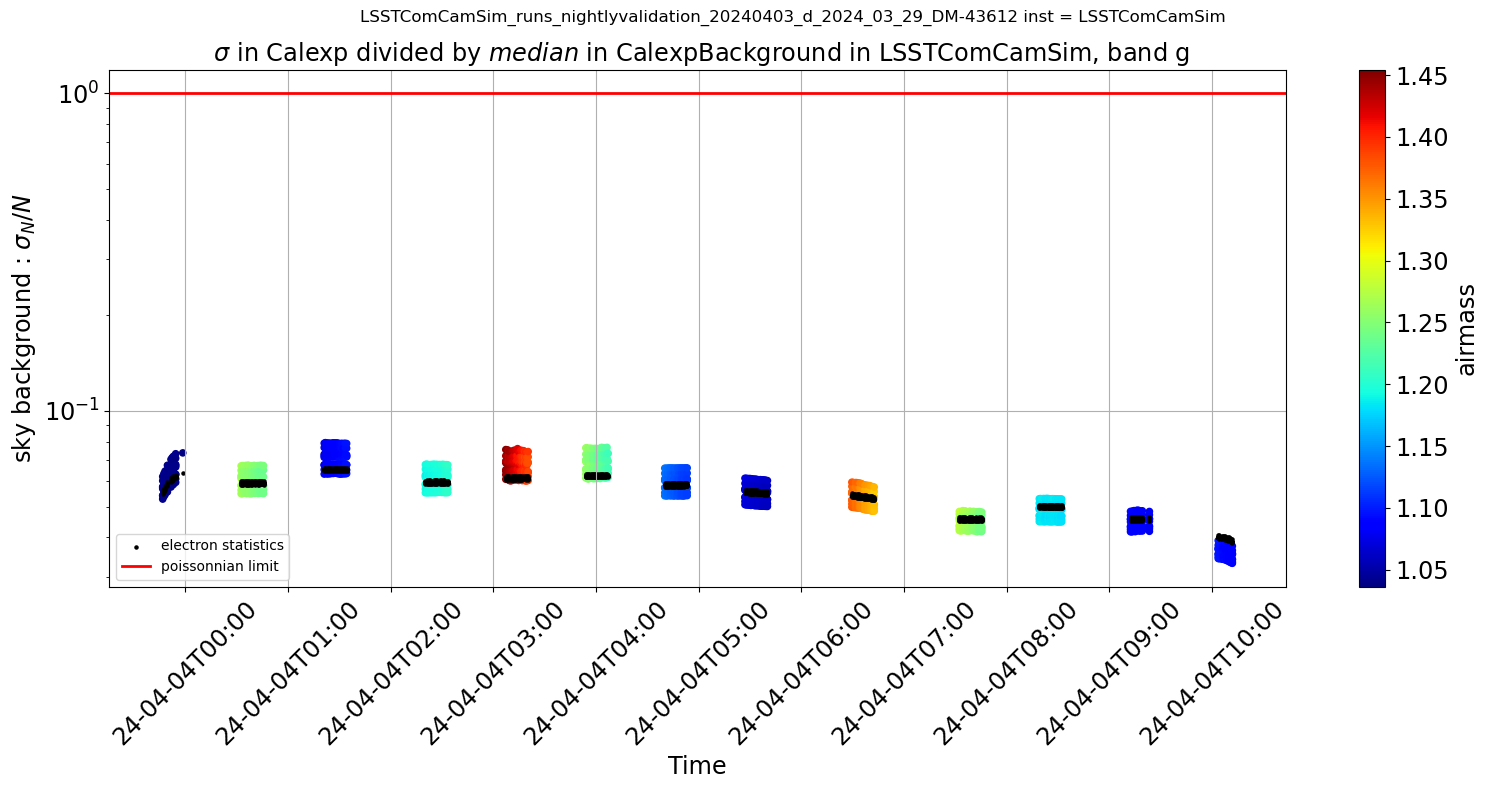

In [36]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in LSSTComCamSim, band g"
df_g.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_g.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics",grid=True)
ax.xaxis.set_major_formatter(date_form)
#ax.set_ylim(0.,10)
ax.set_yscale('log')
ax.axhline(1.,lw=2,color="r",label="poissonnian limit")
ax.set_ylabel("sky background : $\sigma_N/N$")
ax.legend()
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandG_LSSTComCamSim.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Make a straight line fit

- Poissonian Background
$$
\log_{10} \frac{\sigma}{M} = -0.5\log_{10} (g) - 0.5 \log_{10}(N_{ADU}) 
$$

- Electronic Noise $\sigma_N$

$$
\log_{10} \frac{\sigma}{M} = \log_{10} (\sigma_N) -  \log_{10}(N_{ADU}) 
$$

In [37]:
X = df_g["med_bkg"].apply(lambda x : np.log10(x))
Y1 = df_g["sigmatoskybkg"].apply(lambda x : np.log10(x))
Y2 = df_g["sigmatoskybkg_max"].apply(lambda x : np.log10(x))

In [38]:
best_fit1 = fitter(model, X.values, Y1.values)
best_fit2 = fitter(model, X.values, Y2.values)

In [39]:
best_fit1 

<Linear1D(slope=-0.66759713, intercept=0.429315)>

In [40]:
g = np.power(10.,-2*best_fit1.intercept)
g

0.138474563884421

In [41]:
gainfit["g"] = g
slopefit["g"] = best_fit1.slope.value
interceptfit["g"] = best_fit1.intercept.value

In [42]:
best_fit2

<Linear1D(slope=-0.5, intercept=0.)>

In [43]:
textstr = '\n'.join((
    r'Simple linear fit in (log,log) :',
    r'$slope = %.3f$' % (best_fit1.slope.value, ),
    r'$intercept = %.3f$' % (best_fit1.intercept.value, ),
    r'$gain= %.3f$ ADU' % (g, )))

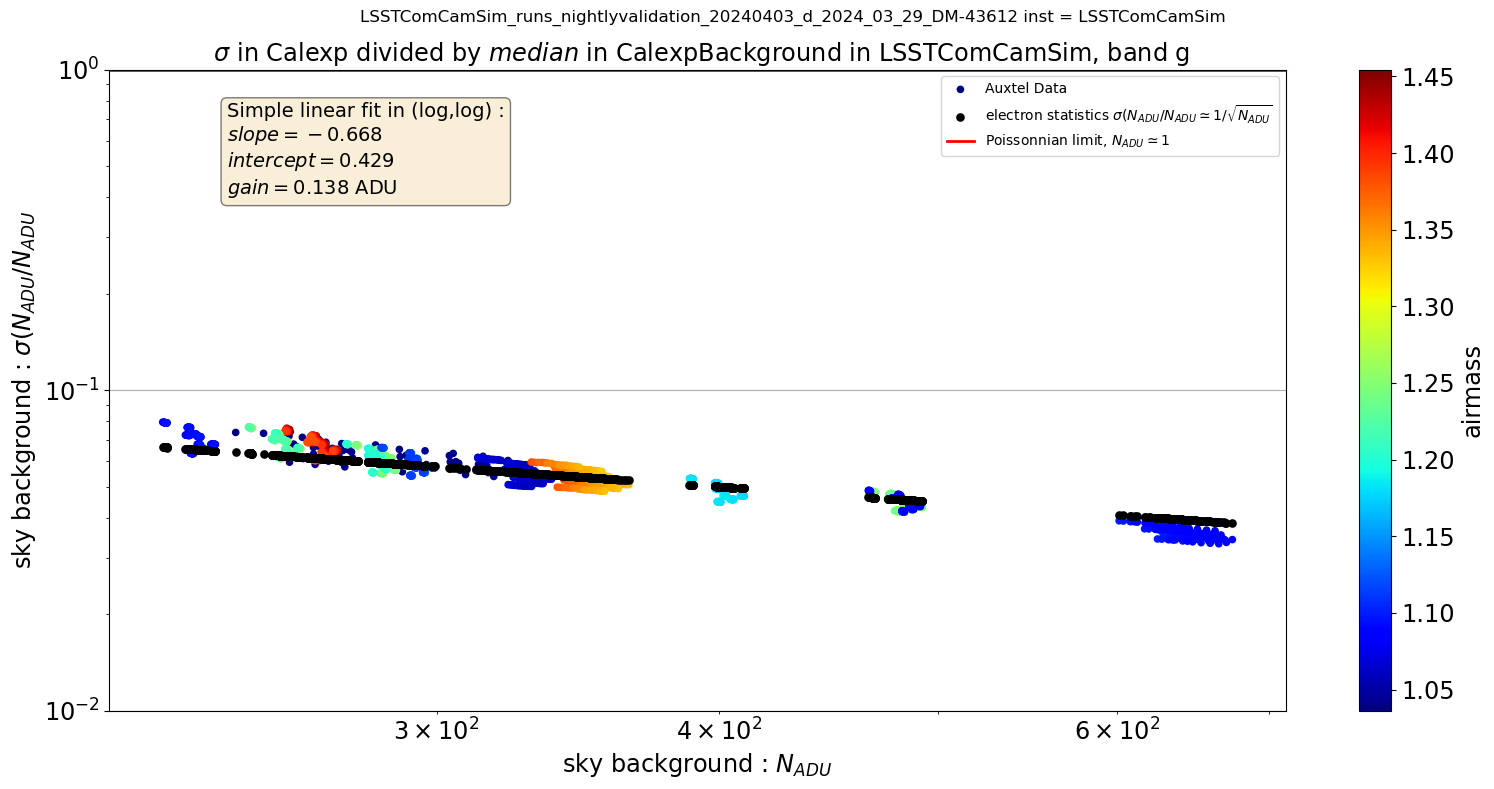

In [44]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in LSSTComCamSim, band g"
df_g.plot.scatter(x="med_bkg",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",label="Auxtel Data",title=title,grid=True)
df_g.plot.scatter(x="med_bkg",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics $\sigma(N_{ADU}/N_{ADU} \simeq 1/\sqrt{N_{ADU}}$",grid=True,lw=4)

ax.set_yscale("log")
ax.set_xscale("log")
ax.axhline(1.,lw=2,color="r",label="Poissonnian limit, $N_{ADU} \simeq 1$")
ax.legend()
ax.set_ylim(1e-2,1)
ax.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

ax.set_ylabel("sky background : $\sigma(N_{ADU}/N_{ADU}$")
ax.set_xlabel("sky background : $N_{ADU}$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandG_LSSTComCamSim.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Sky Background in r band

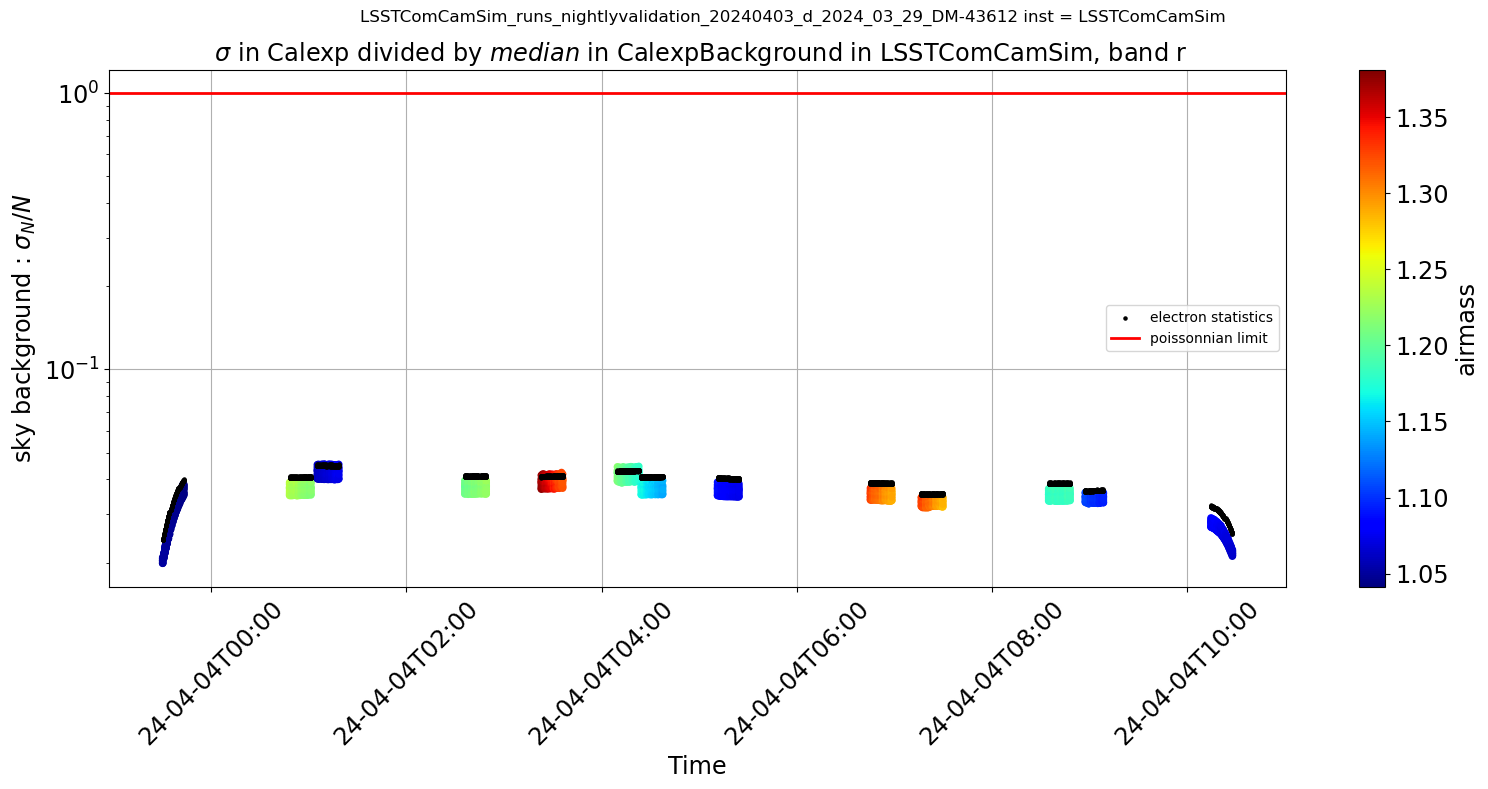

In [45]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in LSSTComCamSim, band r"
df_r.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_r.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics",grid=True)
ax.xaxis.set_major_formatter(date_form)
#ax.set_ylim(0.,10)
ax.set_yscale('log')
ax.axhline(1.,lw=2,color="r",label="poissonnian limit")
ax.legend()
plt.suptitle(suptitle)
ax.set_ylabel("sky background : $\sigma_N/N$")
figname = "calexp_sigmaNbyN_bandR_LSSTComCamSim.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Making a straight line fit

In [46]:
X = df_r["med_bkg"].apply(lambda x : np.log10(x))
Y1 = df_r["sigmatoskybkg"].apply(lambda x : np.log10(x))
Y2 = df_r["sigmatoskybkg_max"].apply(lambda x : np.log10(x))

In [47]:
best_fit1 = fitter(model, X.values, Y1.values)
best_fit2 = fitter(model, X.values, Y2.values)

In [48]:
best_fit1 

<Linear1D(slope=-0.60015768, intercept=0.24580258)>

In [49]:
best_fit2 

<Linear1D(slope=-0.5, intercept=0.)>

In [50]:
g = np.power(10.,-2*best_fit1.intercept)
g

0.32239985188352865

In [51]:
gainfit["r"] = g
slopefit["r"] = best_fit1.slope.value
interceptfit["r"] = best_fit1.intercept.value

In [52]:
textstr = '\n'.join((
    r'Simple linear fit in (log,log) :',
    r'$slope = %.3f$' % (best_fit1.slope.value, ),
    r'$intercept = %.3f$' % (best_fit1.intercept.value, ),
    r'$gain= %.3f$ ADU' % (g, )))

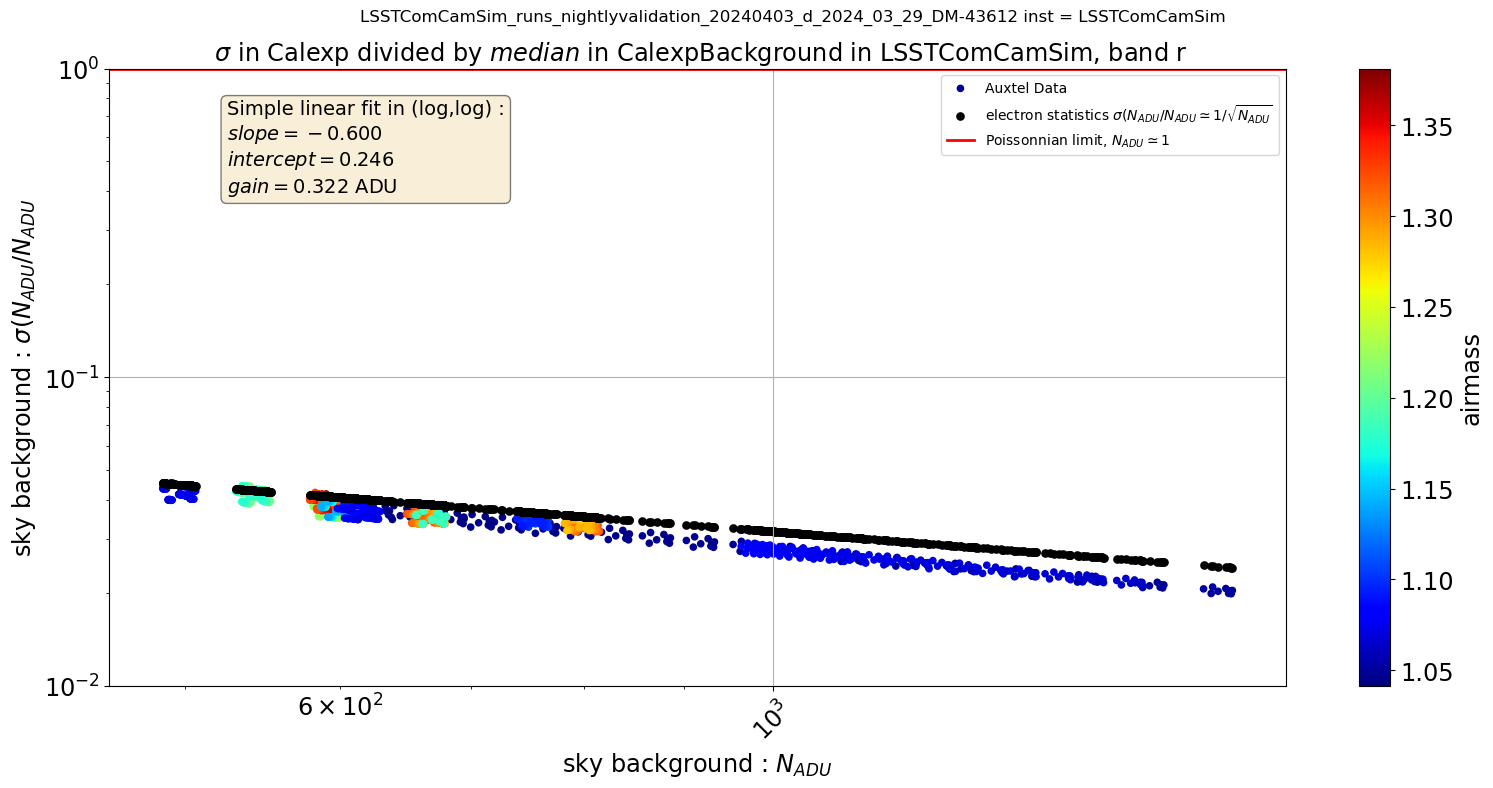

In [53]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in LSSTComCamSim, band r"
df_r.plot.scatter(x="med_bkg",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",label="Auxtel Data",title=title,grid=True)
df_r.plot.scatter(x="med_bkg",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics $\sigma(N_{ADU}/N_{ADU} \simeq 1/\sqrt{N_{ADU}}$",grid=True,lw=4)

ax.set_yscale("log")
ax.set_xscale("log")
ax.axhline(1.,lw=2,color="r",label="Poissonnian limit, $N_{ADU} \simeq 1$")
ax.legend()
ax.set_ylim(1e-2,1)
ax.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

ax.set_ylabel("sky background : $\sigma(N_{ADU}/N_{ADU}$")
ax.set_xlabel("sky background : $N_{ADU}$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandR_LSSTComCamSim.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Sky Background in i band

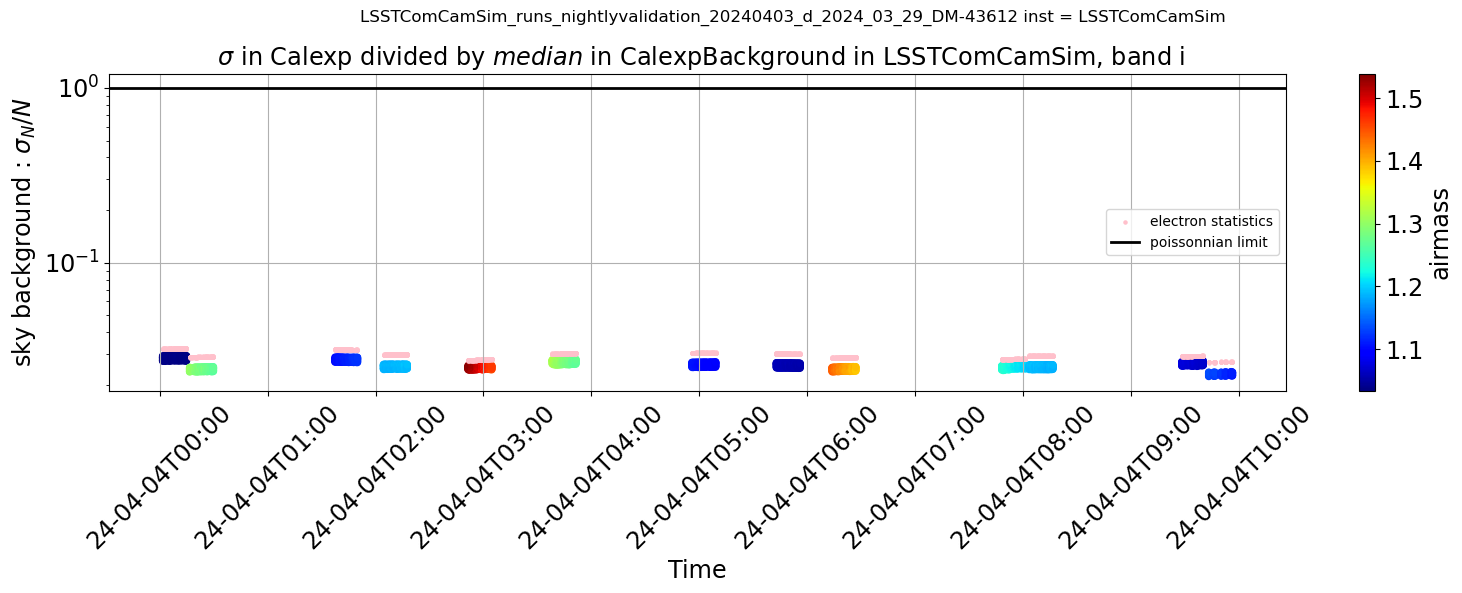

In [54]:
fig, ax = plt.subplots(1,1,figsize=(16,6),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in LSSTComCamSim, band i"
df_i.plot.scatter(x="Time",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",title=title,grid=True)
df_i.plot.scatter(x="Time",y="sigmatoskybkg_max",ax=ax,marker=".",color="pink",rot=45,label="electron statistics",grid=True)
ax.xaxis.set_major_formatter(date_form)
#ax.set_ylim(0.,10)
ax.set_yscale('log')
ax.axhline(1.,lw=2,color="k",label="poissonnian limit")
ax.legend()
plt.suptitle(suptitle)
ax.set_ylabel("sky background : $\sigma_N/N$")
figname = "calexp_sigmaNbyN_bandI_LSSTComCamSim.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

### Make  fit

In [55]:
X = df_i["med_bkg"].apply(lambda x : np.log10(x))
Y1 = df_i["sigmatoskybkg"].apply(lambda x : np.log10(x))
Y2 = df_i["sigmatoskybkg_max"].apply(lambda x : np.log10(x))

In [56]:
best_fit1 = fitter(model, X.values, Y1.values)
best_fit2 = fitter(model, X.values, Y2.values)

In [57]:
best_fit1 

<Linear1D(slope=-0.46592571, intercept=-0.16226891)>

In [58]:
best_fit2 

<Linear1D(slope=-0.5, intercept=-0.)>

In [59]:
g = np.power(10.,-2*best_fit1.intercept)
g

2.1112410602664413

In [60]:
gainfit["i"] = g
slopefit["i"] = best_fit1.slope.value
interceptfit["i"] = best_fit1.intercept.value

In [61]:
textstr = '\n'.join((
    r'Simple linear fit in (log,log) :',
    r'$slope = %.3f$' % (best_fit1.slope.value, ),
    r'$intercept = %.3f$' % (best_fit1.intercept.value, ),
    r'$gain= %.3f$ ADU' % (g, )))

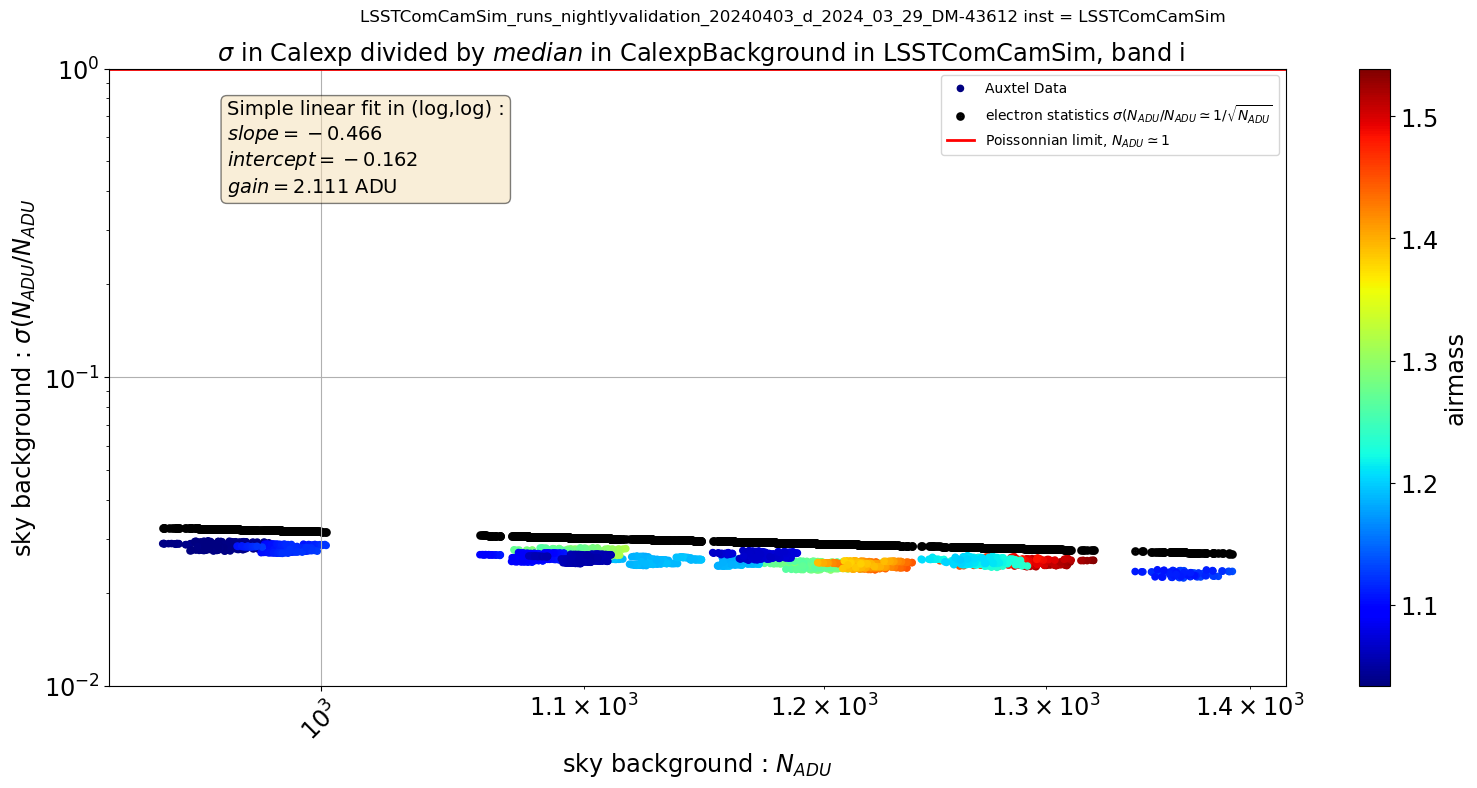

In [62]:
fig, ax = plt.subplots(1,1,figsize=(16,8),sharex=False)
title = f" $\sigma$ in Calexp divided by $median$ in CalexpBackground in LSSTComCamSim, band i"
df_i.plot.scatter(x="med_bkg",y="sigmatoskybkg",ax=ax,marker="o",c="airmass",cmap="jet",rot=45,ylabel="ratio $\sigma$/$median$",label="Auxtel Data",title=title,grid=True)
df_i.plot.scatter(x="med_bkg",y="sigmatoskybkg_max",ax=ax,marker=".",color="k",rot=45,label="electron statistics $\sigma(N_{ADU}/N_{ADU} \simeq 1/\sqrt{N_{ADU}}$",grid=True,lw=4)

ax.set_yscale("log")
ax.set_xscale("log")
ax.axhline(1.,lw=2,color="r",label="Poissonnian limit, $N_{ADU} \simeq 1$")
ax.legend()
ax.set_ylim(1e-2,1)
ax.text(0.1, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

ax.set_ylabel("sky background : $\sigma(N_{ADU}/N_{ADU}$")
ax.set_xlabel("sky background : $N_{ADU}$")
plt.suptitle(suptitle)
figname = "calexp_sigmaNbyN_bandI_LSSTComCamSim.png"
plt.tight_layout()
plt.savefig(figname)
plt.show()

## Summary

In [63]:
df1 = pd.DataFrame(slopefit, index=['slope']).round(4)
df2 = pd.DataFrame(interceptfit, index=['intercept']).round(4)
df3 = pd.DataFrame(gainfit, index=['gain']).round(4)

In [64]:
df_fit = pd.concat([df1,df2,df3])

In [65]:
df_fit

,g,r,i
slope,-0.6676,-0.6002,-0.4659
intercept,0.4293,0.2458,-0.1623
gain,0.1385,0.3224,2.1112


In [66]:
df_fit_t = df_fit.transpose() 

In [67]:
df_fit_t.index.name="band"
df_fit_t

,slope,intercept,gain
band,,,
g,-0.6676,0.4293,0.1385
r,-0.6002,0.2458,0.3224
i,-0.4659,-0.1623,2.1112


In [68]:
df_fit.transpose().to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>slope</th>\n      <th>intercept</th>\n      <th>gain</th>\n    </tr>\n    <tr>\n      <th>band</th>\n      <th></th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>g</th>\n      <td>-0.6676</td>\n      <td>0.4293</td>\n      <td>0.1385</td>\n    </tr>\n    <tr>\n      <th>r</th>\n      <td>-0.6002</td>\n      <td>0.2458</td>\n      <td>0.3224</td>\n    </tr>\n    <tr>\n      <th>i</th>\n      <td>-0.4659</td>\n      <td>-0.1623</td>\n      <td>2.1112</td>\n    </tr>\n  </tbody>\n</table>'

In [69]:
#df_fit.transpose().to_latex()